# Capstone Project - The Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction/Business Problem
## 1. A description of the problem and a discussion of the background

In this project I will compare neiberhoods of two big cities in Europe, Amsterdam and Berlin.

My target audience are people that know one city pretty well and are wondering which neighborhood of the other city is most similar to the one they like.

They could use this data to choose location of their hotel or apartment when visiting or moving to the other city. 

Criteria that I will take into the consideration are, Population density, area, venues nearby

# Data 
## 2. A description of the data and how it will be used to solve the problem. 

I will take postal codes, neigboorhood info, geo location from, **https://postal-codes.cybo.com/germany/berlin/#listcodes**, **https://postal-codes.cybo.com/netherlands/amsterdam/#listcodes** then using the foursquare API, I will obtain data about the venues in each neiborhood to compare them.

The details page on **cybo.com** have **Neighborhoods**, **Coordinates**, **area** and **population** fields 
Foursquare endpoint gives information about the venues **https://api.foursquare.com/v2/venues/explore**

First entry from the Berlin codes:


Postal Code|City|Administrative Region|Population|Area
 --- | --- | --- | --- | --- 
10115|Berlin|Berlin|16,678|2.421 km²

And in the details page **https://postal-codes.cybo.com/germany/10115_berlin-berlin/** fields that I will use:

| | |
:--- | --- 
**Neighborhoods**|Mitte
**Coordinates**|52.533706954560394° / 13.387223860255002°

Interesing information from the API are in the items, especialy venue fields.


Getting data from cybo.com in separate notebook, here I will import the obtained files:

In [142]:
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from IPython.core.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.cm as cm
import matplotlib.colors as colors

In [143]:
def clean_df_codes(df: pd.DataFrame):
    df = df.replace(',','', regex=True)
    df['Population'] = pd.to_numeric(df['Population'], errors='coerce')
    df['Area km²'] = pd.to_numeric(df['Area km²'], errors='coerce')
    df.dropna(inplace=True)
    df['Population density per km²'] = df['Population']/df['Area km²']
    df['Population density per km²'] = df['Population density per km²'].round(2)
    df['Population'] = df['Population'].astype(int)
    return df

In [144]:
berlin_codes_df = pd.read_csv('berlin_codes.csv', delimiter=';')
berlin_codes_df = clean_df_codes(berlin_codes_df)
berlin_codes_df.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²
0,10115,Berlin,Berlin,16678,2.421,6888.89
1,10117,Berlin,Berlin,24223,3.321,7293.89
2,10119,Berlin,Berlin,7408,0.857,8644.11
3,10178,Berlin,Berlin,14069,1.872,7515.49
4,10179,Berlin,Berlin,15897,2.183,7282.18


In [145]:
berlin_details_df = pd.read_csv('berlin_details.csv', delimiter=';', thousands=',')
berlin_details_df.head()

,Postal Code,Median Age,Neighborhoods,Latitude,Longitude
0,10115,43.0,Mitte,52.533707,13.387224
1,10117,43.0,Mitte,52.518746,13.390193
2,10119,43.0,"Bezirk Pankow, Mitte",52.532666,13.407149
3,10178,43.0,Mitte,52.523474,13.412203
4,10179,43.0,"Luisenstadt, Mitte",52.514591,13.419699


In [146]:
amsterdam_codes_df = pd.read_csv('amsterdam_codes.csv', delimiter=';')
amsterdam_codes_df = clean_df_codes(amsterdam_codes_df)
amsterdam_codes_df.rename(columns={'Postal District': 'Postal Code'}, inplace=True)
amsterdam_codes_df.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²
0,1011,Amsterdam,North Holland,6606,1.032,6401.16
1,1012,Amsterdam,North Holland,7067,1.207,5855.01
2,1013,Amsterdam,North Holland,26792,6.300,4252.70
3,1014,Amsterdam,North Holland,15056,2.699,5578.36
4,1015,Amsterdam,North Holland,5926,0.776,7636.60


In [147]:
amsterdam_details_df = pd.read_csv('amsterdam_details.csv', delimiter=';', thousands=',')
amsterdam_details_df.head()

,Postal Code,Median Age,Neighborhoods,Latitude,Longitude
0,1011,36.3,"Amsterdam-Centrum, Stadsdeel Centrum",52.371124,4.903752
1,1012,36.3,"Amsterdam-Centrum, Centrum, De Wallen, Stadsde...",52.373179,4.894910
2,1013,36.3,"Amsterdam-Centrum, Amsterdam-West, Haarlemmerb...",52.387662,4.883396
3,1014,36.3,"Amsterdam-West, Bedrijventerrein Sloterdijk, S...",52.393066,4.853503
4,1015,36.3,"Amsterdam-Centrum, Grachtengordel-West, Jordaan",52.378205,4.882973


In [148]:
berlin_merged = pd.merge(berlin_codes_df, berlin_details_df, on='Postal Code', how='left')
berlin_merged.to_csv('berlin_regions.csv', sep=';')
berlin_merged.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²,Median Age,Neighborhoods,Latitude,Longitude
0,10115,Berlin,Berlin,16678,2.421,6888.89,43.0,Mitte,52.533707,13.387224
1,10117,Berlin,Berlin,24223,3.321,7293.89,43.0,Mitte,52.518746,13.390193
2,10119,Berlin,Berlin,7408,0.857,8644.11,43.0,"Bezirk Pankow, Mitte",52.532666,13.407149
3,10178,Berlin,Berlin,14069,1.872,7515.49,43.0,Mitte,52.523474,13.412203
4,10179,Berlin,Berlin,15897,2.183,7282.18,43.0,"Luisenstadt, Mitte",52.514591,13.419699


In [149]:
amsterdam_merged = pd.merge(amsterdam_codes_df, amsterdam_details_df, on='Postal Code', how='left')
amsterdam_merged.to_csv('amsterdam_regions.csv', sep=';')
amsterdam_merged.head()

,Postal Code,City,Administrative Region,Population,Area km²,Population density per km²,Median Age,Neighborhoods,Latitude,Longitude
0,1011,Amsterdam,North Holland,6606,1.032,6401.16,36.3,"Amsterdam-Centrum, Stadsdeel Centrum",52.371124,4.903752
1,1012,Amsterdam,North Holland,7067,1.207,5855.01,36.3,"Amsterdam-Centrum, Centrum, De Wallen, Stadsde...",52.373179,4.894910
2,1013,Amsterdam,North Holland,26792,6.300,4252.70,36.3,"Amsterdam-Centrum, Amsterdam-West, Haarlemmerb...",52.387662,4.883396
3,1014,Amsterdam,North Holland,15056,2.699,5578.36,36.3,"Amsterdam-West, Bedrijventerrein Sloterdijk, S...",52.393066,4.853503
4,1015,Amsterdam,North Holland,5926,0.776,7636.60,36.3,"Amsterdam-Centrum, Grachtengordel-West, Jordaan",52.378205,4.882973


In [150]:
berlin_merged.describe()

,Postal Code,Population,Area km²,Population density per km²,Median Age,Latitude,Longitude
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,12262.685567,17621.417526,5.484062,5355.793144,43.095876,52.505112,13.393498
std,1287.341587,10837.421963,8.476452,2050.216635,0.559777,0.055279,0.116044
min,10115.000000,2869.000000,0.444000,277.140000,43.000000,52.363244,13.143126
25%,10823.500000,9730.250000,1.619250,4190.742500,43.000000,52.467486,13.317487
50%,12356.000000,15129.000000,2.952000,5876.970000,43.000000,52.504849,13.384287
75%,13354.500000,22677.500000,6.500000,6699.890000,43.000000,52.542604,13.460486
max,15562.000000,57275.000000,77.500000,8950.650000,48.000000,52.642215,13.799300


In [151]:
amsterdam_merged.describe()

,Postal Code,Population,Area km²,Population density per km²,Median Age,Latitude,Longitude
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,1060.358025,9830.283951,2.646741,5044.703704,36.403704,52.364022,4.892978
std,29.733949,5809.643077,2.612032,1851.930209,0.667354,0.029773,0.057825
min,1011.000000,878.000000,0.242000,175.110000,36.300000,52.293492,4.758401
25%,1034.000000,6128.000000,1.128000,4252.700000,36.300000,52.347895,4.853503
50%,1061.000000,8852.000000,1.880000,5398.920000,36.300000,52.362742,4.894881
75%,1083.000000,13174.000000,2.915000,6486.340000,36.300000,52.387662,4.935605
max,1114.000000,28120.000000,13.900000,7636.600000,42.300000,52.419563,5.016719


In [152]:
address_berlin = 'Berlin, Germany'
address_amsterdam = 'Amsterdam, Netherlands'

geolocator = Nominatim(user_agent="explorer")
berlin_location = geolocator.geocode(address_berlin)
berlin_lat, berlin_lon = (berlin_location.latitude, berlin_location.longitude)

amsterdam_location = geolocator.geocode(address_amsterdam)
amsterdam_lat, amsterdam_lon = (amsterdam_location.latitude, amsterdam_location.longitude)
print(f'The geograpical coordinate of Berlin are {berlin_lat}, {berlin_lon}. and Amsterdam are {amsterdam_lat}, {amsterdam_lon}')

The geograpical coordinate of Berlin are 52.5170365, 13.3888599. and Amsterdam are 52.3727598, 4.8936041


In [153]:
def get_map(df: pd.DataFrame, city_lat, city_lon, zoom=10):
    map = folium.Map(location=[city_lat, city_lon], zoom_start=zoom)

    # add markers to map
    for lat, lng, admin_region, neighborhoods in zip(df['Latitude'], df['Longitude'], df['Administrative Region'], df['Neighborhoods']):
        label = f'{neighborhoods}, {admin_region}'
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)  
        
    return map

In [154]:
def show_maps_sidebyside(map1, map2):
    htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 49.7%; margin: 0 auto; border: 2px solid black"></iframe>'
            '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 49.7%; margin: 0 auto; border: 2px solid black"></iframe>'
            .format(map1.get_root().render().replace('"', '&quot;'),500,500,
                    map2.get_root().render().replace('"', '&quot;'),500,500))
    display(htmlmap)
 

In [155]:
berlin_map = get_map(berlin_merged, berlin_lat, berlin_lon, 10)
amsterdam_map = get_map(amsterdam_merged, amsterdam_lat, amsterdam_lon, 11)

In [156]:
%%capture --no-display
show_maps_sidebyside(berlin_map, amsterdam_map)

In [157]:
berlin_venues = pd.read_csv('berlin_venues.csv', sep=';')
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")
berlin_onehot['Postal Code'] = berlin_venues['Neighborhood'] 

In [158]:
cols = list(berlin_onehot)
cols.insert(0, cols.pop(cols.index('Postal Code')))
berlin_onehot = berlin_onehot.loc[:, cols]
berlin_grouped = berlin_onehot.groupby('Postal Code').mean().reset_index()
berlin_grouped.head()

,Postal Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,10115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.0
1,10117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.030000,0.00,0.0,0.0,0.01,0.0,0.0
2,10119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.021978,0.00,0.0,0.0,0.00,0.0,0.0
3,10178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.00,0.0,0.0
4,10179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.0


In [159]:
amsterdam_venues = pd.read_csv('amsterdam_venues.csv', sep=';')
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")
amsterdam_onehot['Postal Code'] = amsterdam_venues['Neighborhood'] 

In [160]:
cols = list(amsterdam_onehot)
cols.insert(0, cols.pop(cols.index('Postal Code')))
amsterdam_onehot = amsterdam_onehot.loc[:, cols]
amsterdam_grouped = amsterdam_onehot.groupby('Postal Code').mean().reset_index()
amsterdam_grouped.head()

,Postal Code,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1011,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.025,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.02,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,1013,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.010000,0.000000,0.000000,0.020000,0.0,0.0
3,1014,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,1015,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.010989,0.010989,0.010989,0.010989,0.0,0.0


In [161]:
berlin_conds = berlin_merged[['Postal Code', 'Population density per km²', 'Median Age']]
amsterdam_conds = amsterdam_merged[['Postal Code', 'Population density per km²', 'Median Age']]

both_cities_conds = pd.concat([berlin_conds, amsterdam_conds])
print("Berlin df: ", berlin_conds.shape, "Amsterdam df: ", amsterdam_conds.shape, "both cities df: ", both_cities_conds.shape)

Berlin df:  (194, 3) Amsterdam df:  (81, 3) both cities df:  (275, 3)


In [162]:
both_cities_conds_id = both_cities_conds.set_index('Postal Code')
min_max_scaler = preprocessing.MinMaxScaler()
both_cities_conds = pd.DataFrame(min_max_scaler.fit_transform(both_cities_conds_id), columns=both_cities_conds_id.columns, index=both_cities_conds_id.index)
both_cities_conds = both_cities_conds.reset_index()
both_cities_conds.head()

,Postal Code,Population density per km²,Median Age
0,10115,0.765056,0.57265
1,10117,0.811207,0.57265
2,10119,0.965069,0.57265
3,10178,0.836459,0.57265
4,10179,0.809873,0.57265


In [163]:
both_cities_grouped = pd.concat([amsterdam_grouped, berlin_grouped])
both_cities_grouped.fillna(0, inplace=True)
print("Berlin df: ", berlin_grouped.shape, "Amsterdam df: ", amsterdam_grouped.shape, "both cities df: ", both_cities_grouped.shape)
both_cities_grouped.head()

Berlin df:  (194, 388) Amsterdam df:  (81, 305) both cities df:  (275, 436)


,Postal Code,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Theme Park,Theme Park Ride / Attraction,Trattoria/Osteria,Tree,Turkish Home Cooking Restaurant,Vacation Rental,Volleyball Court,Watch Shop,Waterfront,Wings Joint
0,1011,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.025,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1013,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1014,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1015,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
both_cities_clustering_ready = pd.merge(both_cities_conds, both_cities_grouped, on='Postal Code')
print("Grouped df: ", both_cities_grouped.shape, "Conds df: ", both_cities_conds.shape, "Clustering df: ", both_cities_clustering_ready.shape)
both_cities_clustering_ready.sort_values(by=['Postal Code'], inplace=True)
both_cities_clustering_ready.head()

Grouped df:  (275, 436) Conds df:  (275, 3) Clustering df:  (275, 438)


,Postal Code,Population density per km²,Median Age,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,...,Theme Park,Theme Park Ride / Attraction,Trattoria/Osteria,Tree,Turkish Home Cooking Restaurant,Vacation Rental,Volleyball Court,Watch Shop,Waterfront,Wings Joint
194,1011,0.709478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,1012,0.647242,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,1013,0.464654,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,1014,0.615717,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,1015,0.850260,0.0,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)

C:\Users\COMARCH\AppData\Local\Temp/ipykernel_15012/948272522.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)


In [166]:
results = []
for k in range(1, 15):
    kclusters = k
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(both_cities_clustering)
    score = kmeans.score(both_cities_clustering)
    results.append((kclusters, score))
result_df = pd.DataFrame(results)

<AxesSubplot:xlabel='0'>

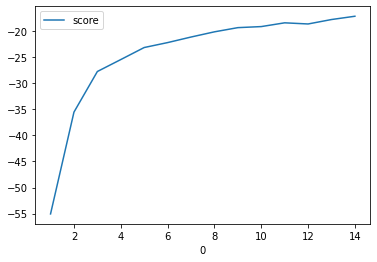

In [167]:
result_df.plot.line(y=1, x=0, label='score')

In [168]:
both_cities_clustering_ready.drop('Median Age', axis=1, inplace=True)
both_cities_clustering_ready.head()

,Postal Code,Population density per km²,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,...,Theme Park,Theme Park Ride / Attraction,Trattoria/Osteria,Tree,Turkish Home Cooking Restaurant,Vacation Rental,Volleyball Court,Watch Shop,Waterfront,Wings Joint
194,1011,0.709478,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,1012,0.647242,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,1013,0.464654,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,1014,0.615717,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,1015,0.850260,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
# set number of clusters
kclusters = 4


both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(both_cities_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

C:\Users\COMARCH\AppData\Local\Temp/ipykernel_15012/3539446756.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  both_cities_clustering = both_cities_clustering_ready.drop('Postal Code', 1)


array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0])

In [170]:
kmeans.score(both_cities_clustering)

-21.351676996765995

In [171]:
both_cities_merged = pd.concat([berlin_merged, amsterdam_merged])
both_cities_merged.sort_values(by=['Postal Code'], inplace=True)

both_cities_merged.insert(1, 'Cluster Labels', kmeans.labels_)

both_cities_merged.head()

,Postal Code,Cluster Labels,City,Administrative Region,Population,Area km²,Population density per km²,Median Age,Neighborhoods,Latitude,Longitude
0,1011,1,Amsterdam,North Holland,6606,1.032,6401.16,36.3,"Amsterdam-Centrum, Stadsdeel Centrum",52.371124,4.903752
1,1012,1,Amsterdam,North Holland,7067,1.207,5855.01,36.3,"Amsterdam-Centrum, Centrum, De Wallen, Stadsde...",52.373179,4.894910
2,1013,0,Amsterdam,North Holland,26792,6.300,4252.70,36.3,"Amsterdam-Centrum, Amsterdam-West, Haarlemmerb...",52.387662,4.883396
3,1014,0,Amsterdam,North Holland,15056,2.699,5578.36,36.3,"Amsterdam-West, Bedrijventerrein Sloterdijk, S...",52.393066,4.853503
4,1015,1,Amsterdam,North Holland,5926,0.776,7636.60,36.3,"Amsterdam-Centrum, Grachtengordel-West, Jordaan",52.378205,4.882973


In [172]:
berlin_map = get_map(berlin_merged, berlin_lat, berlin_lon, 10)
amsterdam_map = get_map(amsterdam_merged, amsterdam_lat, amsterdam_lon, 11)

In [173]:
# create map
berlin_cluster_map = folium.Map(location=[berlin_lat, berlin_lon], zoom_start=10)
amsterdam_cluster_map = folium.Map(location=[amsterdam_lat, amsterdam_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh, cluster in zip(both_cities_merged['Latitude'], both_cities_merged['Longitude'], both_cities_merged['Postal Code'], both_cities_merged['Neighborhoods'], both_cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(berlin_cluster_map)

markers_colors = []
for lat, lon, poi, neigh, cluster in zip(both_cities_merged['Latitude'], both_cities_merged['Longitude'], both_cities_merged['Postal Code'], both_cities_merged['Neighborhoods'], both_cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(amsterdam_cluster_map)

In [174]:
%%capture --no-display
show_maps_sidebyside(berlin_cluster_map, amsterdam_cluster_map)

In [175]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
    
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Postal Code'] = both_cities_grouped['Postal Code']

for ind in np.arange(both_cities_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(both_cities_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1011,Bar,Hotel,Café,Chinese Restaurant,Grocery Store,Cocktail Bar,Bike Rental / Bike Share,Ice Cream Shop,Bagel Shop,Convenience Store
1,1012,Hotel,Coffee Shop,Bar,Café,Cocktail Bar,Bakery,Museum,Marijuana Dispensary,Salon / Barbershop,French Restaurant
2,1013,Bar,Restaurant,Coffee Shop,Italian Restaurant,Café,Tapas Restaurant,Deli / Bodega,Hotel,Thai Restaurant,Market
3,1014,Soccer Field,Music Venue,Thrift / Vintage Store,Paper / Office Supplies Store,Canal Lock,Fast Food Restaurant,Farm,Dog Run,Nightclub,Climbing Gym
4,1015,Bar,Italian Restaurant,Café,Sandwich Place,Hotel,Coffee Shop,Thai Restaurant,Spanish Restaurant,Seafood Restaurant,Indonesian Restaurant


In [176]:
result_df = pd.merge(both_cities_merged[['Postal Code', 'Cluster Labels', 'City', 'Population density per km²', 'Neighborhoods']].sort_values('Postal Code'),
    venues_sorted, on='Postal Code')

In [177]:
result_df.loc[result_df['Cluster Labels']  == 0].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
155,12157,0,Berlin,5233.69,"Bezirk Steglitz-Zehlendorf, Bezirk Tempelhof-S...",Soccer Field,Park,Gym,Ice Cream Shop,Track,Flower Shop,Supermarket,Plaza,Warehouse Store,Turkish Restaurant
127,10787,0,Berlin,3839.74,"Bezirk Charlottenburg-Wilmersdorf, Bezirk Temp...",Zoo Exhibit,Hotel,Hotel Bar,Playground,Restaurant,Lounge,Breakfast Spot,Spanish Restaurant,Spa,Monument / Landmark
72,1102,0,Amsterdam,4738.59,"Amsterdam-Zuidoost, Bijlmer-Centrum",Chinese Restaurant,Clothing Store,Park,Bakery,Soccer Stadium,Hotel,Plaza,Bar,Supermarket,Multiplex
255,14050,0,Berlin,4021.79,"Bezirk Charlottenburg-Wilmersdorf, Neu-Westend",Seafood Restaurant,Supermarket,Storage Facility,Chinese Restaurant,Soccer Field,Argentinian Restaurant,Plaza,Vietnamese Restaurant,Tunnel,Warehouse Store
216,13129,0,Berlin,3077.30,"Bezirk Pankow, Blankenburg",Café,Bus Stop,Greek Restaurant,Golf Course,Supermarket,Gas Station,Restaurant,Accessories Store,Udon Restaurant,Windmill
212,13088,0,Berlin,4511.30,"Bezirk Pankow, Weißensee",Tram Station,German Restaurant,Park,Supermarket,Playground,Laser Tag,Indoor Play Area,Church,Lake,Soccer Field
44,1065,0,Amsterdam,5034.04,"Amsterdam Nieuw-West, Slotervaart",Asian Restaurant,Plaza,Steakhouse,Moroccan Restaurant,Italian Restaurant,Grocery Store,Bakery,Sandwich Place,Comfort Food Restaurant,Soccer Field
69,1097,0,Amsterdam,5642.60,"Amsterdam-Oost, Stadsdeel Oost",Soccer Field,French Restaurant,Fast Food Restaurant,Supermarket,Plaza,Music Store,Farmers Market,Garden Center,Drugstore,Grocery Store
260,14059,0,Berlin,5216.52,"Bezirk Charlottenburg-Wilmersdorf, Charlottenburg",Italian Restaurant,Art Museum,Playground,Café,German Restaurant,Bakery,Boat or Ferry,Soup Place,Drugstore,Russian Restaurant
2,1013,0,Amsterdam,4252.70,"Amsterdam-Centrum, Amsterdam-West, Haarlemmerb...",Bar,Restaurant,Coffee Shop,Italian Restaurant,Café,Tapas Restaurant,Deli / Bodega,Hotel,Thai Restaurant,Market


In [178]:
result_df.loc[result_df['Cluster Labels']  == 1].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
227,13357,1,Berlin,7458.53,"Gesundbrunnen, Mitte",Bar,Turkish Restaurant,Platform,Supermarket,Hotel,Bookstore,Drugstore,Café,Clothing Store,Chocolate Shop
144,12051,1,Berlin,6477.11,"Bezirk Neukölln, Karl-Marx-Straße, Schillerkiez",Café,Park,Vietnamese Restaurant,Coffee Shop,Pub,Turkish Restaurant,Supermarket,Doner Restaurant,Ice Cream Shop,Bar
140,12043,1,Berlin,7370.90,"Bezirk Neukölln, Karl-Marx-Straße, Neukölln",Café,Coffee Shop,Bar,Middle Eastern Restaurant,Bistro,Food & Drink Shop,German Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Thrift / Vintage Store
105,10555,1,Berlin,6992.58,Mitte,Café,Doner Restaurant,Vietnamese Restaurant,Pizza Place,Bakery,Food Court,Organic Grocery,Shawarma Place,Drugstore,Grocery Store
1,1012,1,Amsterdam,5855.01,"Amsterdam-Centrum, Centrum, De Wallen, Stadsde...",Hotel,Coffee Shop,Bar,Café,Cocktail Bar,Bakery,Museum,Marijuana Dispensary,Salon / Barbershop,French Restaurant
17,1031,1,Amsterdam,5582.36,"Amsterdam-Noord, Stadsdeel Noord",Café,Bus Stop,Restaurant,Cheese Shop,Bar,Bus Station,Thai Restaurant,Bakery,Grocery Store,Ethiopian Restaurant
94,10365,1,Berlin,6561.82,"Bezirk Lichtenberg, Rüdigerstraße",Vietnamese Restaurant,Tram Station,Market,Supermarket,Park,Music Venue,Hotel,Soccer Field,Gym / Fitness Center,Bowling Alley
235,13439,1,Berlin,5733.53,"Bezirk Reinickendorf, Märkisches Viertel",Pharmacy,Athletics & Sports,Electronics Store,Garden Center,Drugstore,Bank,Gym,Gym / Fitness Center,Bus Stop,Shopping Mall
123,10779,1,Berlin,7570.93,"Bezirk Charlottenburg-Wilmersdorf, Bezirk Temp...",German Restaurant,Trattoria/Osteria,Bakery,Russian Restaurant,Dim Sum Restaurant,Chinese Restaurant,Supermarket,Ice Cream Shop,Sushi Restaurant,Plaza
57,1079,1,Amsterdam,6009.52,"Amsterdam-Zuid, Rijnbuurt",Café,Supermarket,Electronics Store,Italian Restaurant,Hotel,Snack Place,Drugstore,Neighborhood,Boutique,Deli / Bodega


In [179]:
result_df.loc[result_df['Cluster Labels']  == 2].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,10367,2,Berlin,6491.19,"Bezirk Lichtenberg, Fennpfuhl, Rüdigerstraße",Supermarket,Tram Station,Vietnamese Restaurant,Greek Restaurant,Bistro,Hotel,Squash Court,Park,Escape Room,Falafel Restaurant
186,12524,2,Berlin,4854.49,"Altglienicke, Bezirk Treptow-Köpenick",Supermarket,Bowling Alley,Greek Restaurant,Bakery,Miscellaneous Shop,Home Service,Accessories Store,Whisky Bar,Warehouse Store,Vietnamese Restaurant
234,13437,2,Berlin,5639.72,"Bezirk Reinickendorf, Wittenau",Supermarket,Italian Restaurant,German Restaurant,Restaurant,Chinese Restaurant,Light Rail Station,Church,Indian Restaurant,Concert Hall,Mediterranean Restaurant
187,12526,2,Berlin,4139.13,Bezirk Treptow-Köpenick,Supermarket,Light Rail Station,Home Service,Food Truck,Discount Store,Accessories Store,Tunnel,Whisky Bar,Warehouse Store,Vietnamese Restaurant
21,1035,2,Amsterdam,5044.34,Amsterdam-Noord,Bus Stop,Supermarket,Pharmacy,Train Station,Whisky Bar,Warehouse Store,Vietnamese Restaurant,Video Store,Vegetarian / Vegan Restaurant,VR Cafe
179,12359,2,Berlin,5551.25,"Bezirk Neukölln, Britz",Supermarket,Gas Station,Mini Golf,Bus Stop,Metro Station,Hotel,Liquor Store,Soccer Field,Eastern European Restaurant,Park
160,12167,2,Berlin,5907.22,"Bezirk Steglitz-Zehlendorf, Steglitz",Bus Stop,Pastry Shop,Supermarket,Automotive Shop,Organic Grocery,Currywurst Joint,Steakhouse,Park,Bakery,Turkish Restaurant
161,12169,2,Berlin,5503.75,"Bezirk Steglitz-Zehlendorf, Steglitz",Bus Stop,Planetarium,Park,Mini Golf,Supermarket,Gym,Eastern European Restaurant,Thai Restaurant,Pool,Bowling Green
166,12247,2,Berlin,6123.70,"Bezirk Steglitz-Zehlendorf, Lankwitz",Drugstore,Supermarket,Skating Rink,Ice Cream Shop,Bus Stop,Liquor Store,Steakhouse,Movie Theater,Italian Restaurant,German Restaurant
177,12355,2,Berlin,5235.69,"Bezirk Neukölln, Rudow",Italian Restaurant,Supermarket,Plaza,Trail,Drugstore,Greek Restaurant,Bank,Convenience Store,Health & Beauty Service,Park


In [180]:
result_df.loc[result_df['Cluster Labels']  == 3].sample(15)

,Postal Code,Cluster Labels,City,Population density per km²,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,1047,3,Amsterdam,2678.10,"Westelijk Havengebied, Westpoort",Campground,Coffee Shop,Farm,Bistro,Bar,Golf Course,Boat or Ferry,Hobby Shop,Windmill,Whisky Bar
247,13589,3,Berlin,2212.71,"Bezirk Spandau, Spandau",Supermarket,Bus Stop,Snack Place,Drugstore,Accessories Store,Tunnel,Windmill,Whisky Bar,Warehouse Store,Vietnamese Restaurant
261,14089,3,Berlin,979.42,"Bezirk Spandau, Kladow",Supermarket,Bus Stop,Park,Playground,Coffee Shop,Forest,Ice Cream Shop,Liquor Store,History Museum,Financial or Legal Service
11,1023,3,Amsterdam,2359.65,Amsterdam-Noord,Supermarket,Snack Place,Indonesian Restaurant,Tennis Court,Concert Hall,Convenience Store,Bakery,Bar,Park,Discount Store
257,14053,3,Berlin,2588.81,"Bezirk Charlottenburg-Wilmersdorf, Pichelsberg",Soccer Stadium,Lounge,Sports Club,Sporting Goods Shop,Athletics & Sports,Amphitheater,Stadium,Pool,Scenic Lookout,Restaurant
206,13051,3,Berlin,2379.31,"Bezirk Lichtenberg, Lichtenberg",Tram Station,Light Rail Station,Discount Store,German Restaurant,Volleyball Court,Soccer Field,Farm,Miscellaneous Shop,Chinese Restaurant,Supermarket
14,1026,3,Amsterdam,237.58,"Amsterdam-Noord, Waterland",Restaurant,Café,Burger Joint,Grocery Store,Diner,Garden,Tunnel,Harbor / Marina,Bus Stop,Pier
262,14109,3,Berlin,614.06,"Bezirk Steglitz-Zehlendorf, Wannsee",German Restaurant,Supermarket,Harbor / Marina,Boat or Ferry,Bakery,Hotel,Art Gallery,Pier,Bus Stop,Beach
16,1028,3,Amsterdam,175.11,"Amsterdam-Noord, Lindenholt",Campground,Café,Dairy Store,Lake,Diner,Turkish Restaurant,Wine Bar,Windmill,Whisky Bar,Warehouse Store
239,13503,3,Berlin,1235.48,"Bezirk Reinickendorf, Heiligensee",Insurance Office,Supermarket,Light Rail Station,Italian Restaurant,Trattoria/Osteria,Gas Station,Organic Grocery,Outdoor Sculpture,Theme Restaurant,Tram Station
